In [1]:
!pip install websockets

In [2]:
# ============================================================
# CROSS-EXCHANGE ARBITRAGE DETECTOR
# Monitors Bitcoin prices across multiple exchanges in real-time
# ============================================================
# Async & WebSocket
import asyncio
import websockets
import json

# Data handling
import pandas as pd
import numpy as np
from datetime import datetime
import csv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (for later)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Logging
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('darkgrid')

print("✓ All imports successful")
print(f"✓ Setup complete - {datetime.now()}")

✓ All imports successful
✓ Setup complete - 2026-02-11 14:29:03.167763


In [4]:
# ============================================================
# TRANSACTION COST MODEL & SHARED DATA STRUCTURES
# ============================================================

class TransactionCostModel:
    """
    Calculates real profitability after all transaction costs
    """

    def __init__(self):
        # Trading fees (as decimals)
        self.binance_taker_fee = 0.0001   # 0.1%
        self.coinbase_taker_fee = 0.000  # 0.0%
        self.kraken_taker_fee = 0.0016   # 0.26%

        # Withdrawal fees (fixed USD)
        self.withdrawal_fee_btc = 0.0   # $0.0 to withdraw BTC

        # Minimum trade size
        self.min_trade_size_usd = 100.0

    def calculate_net_profit(self, buy_exchange, buy_price, sell_exchange, sell_price, trade_size_usd=1000):
        """
        Calculate net profit for arbitrage opportunity

        Args:
            buy_exchange: 'binance', 'coinbase', or 'kraken'
            buy_price: Ask price on buy exchange
            sell_exchange: 'binance', 'coinbase', or 'kraken'
            sell_price: Bid price on sell exchange
            trade_size_usd: Amount to trade in USD

        Returns:
            net_profit_usd: Profit after all fees (negative = loss)
        """

        # Get fees for exchanges
        buy_fee_rate = self._get_fee(buy_exchange)
        sell_fee_rate = self._get_fee(sell_exchange)

        # Calculate BTC amount
        btc_amount = trade_size_usd / buy_price

        # Gross profit
        gross_profit = (sell_price - buy_price) * btc_amount

        # Trading fees
        buy_fee = trade_size_usd * buy_fee_rate
        sell_fee = (sell_price * btc_amount) * sell_fee_rate

        # Withdrawal fee
        withdrawal_fee = self.withdrawal_fee_btc

        # Net profit
        net_profit = gross_profit - buy_fee - sell_fee - withdrawal_fee

        return net_profit

    def _get_fee(self, exchange):
        """Get fee rate for exchange"""
        fees = {
            'binance': self.binance_taker_fee,
            'coinbase': self.coinbase_taker_fee,
            'kraken': self.kraken_taker_fee
        }
        return fees.get(exchange, 0.001)  # Default 0.1%

    def is_profitable(self, buy_exchange, buy_price, sell_exchange, sell_price, trade_size_usd=1000):
        """
        Check if opportunity is profitable

        Returns:
            bool: True if net profit > 0
        """
        net_profit = self.calculate_net_profit(buy_exchange, buy_price, sell_exchange, sell_price, trade_size_usd)
        return net_profit > 0

    def get_fee_breakdown(self, buy_exchange, buy_price, sell_exchange, sell_price, trade_size_usd=1000):
        """
        Get detailed breakdown of all fees

        Returns:
            dict: Breakdown of fees and profit
        """
        buy_fee_rate = self._get_fee(buy_exchange)
        sell_fee_rate = self._get_fee(sell_exchange)
        btc_amount = trade_size_usd / buy_price

        gross_profit = (sell_price - buy_price) * btc_amount
        buy_fee = trade_size_usd * buy_fee_rate
        sell_fee = (sell_price * btc_amount) * sell_fee_rate
        withdrawal_fee = self.withdrawal_fee_btc
        net_profit = gross_profit - buy_fee - sell_fee - withdrawal_fee

        return {
            'gross_profit': gross_profit,
            'buy_fee': buy_fee,
            'sell_fee': sell_fee,
            'withdrawal_fee': withdrawal_fee,
            'total_fees': buy_fee + sell_fee + withdrawal_fee,
            'net_profit': net_profit,
            'profitable': net_profit > 0
        }


# ============================================================
# SHARED DATA STRUCTURE FOR MULTI-EXCHANGE MONITORING
# ============================================================

# Global dictionary to store latest prices from all exchanges
exchange_prices = {
    'binance': {
        'bid': None,
        'ask': None,
        'timestamp': None,
        'connected': False
    },
    'coinbase': {
        'bid': None,
        'ask': None,
        'timestamp': None,
        'connected': False
    },
    'kraken': {
        'bid': None,
        'ask': None,
        'timestamp': None,
        'connected': False
    }
}

# Initialize fee calculator
fee_calculator = TransactionCostModel()

print("✓ TransactionCostModel created")
print("✓ Shared data structure initialized")
print(f"✓ Fee rates: Binance {fee_calculator.binance_taker_fee*100}%, Coinbase {fee_calculator.coinbase_taker_fee*100}%")

✓ TransactionCostModel created
✓ Shared data structure initialized
✓ Fee rates: Binance 0.01%, Coinbase 0.0%


In [7]:
# ============================================================
# BINANCE WEBSOCKET STREAM
# ============================================================

async def binance_stream():
    """
    Connect to Binance WebSocket and update prices in real-time
    """
    uri = "wss://stream.binance.com:9443/ws/btcusdt@depth20@100ms"

    while True:  # Auto-reconnect loop
        try:
            logging.info("Connecting to Binance...")

            async with websockets.connect(uri) as ws:
                logging.info("✓ Connected to Binance")
                exchange_prices['binance']['connected'] = True

                while True:
                    msg = await ws.recv()
                    data = json.loads(msg)

                    # Extract best bid/ask
                    best_bid = float(data['bids'][0][0])
                    best_ask = float(data['asks'][0][0])

                    # Update shared data structure
                    exchange_prices['binance']['bid'] = best_bid
                    exchange_prices['binance']['ask'] = best_ask
                    exchange_prices['binance']['timestamp'] = datetime.now()

        except websockets.exceptions.ConnectionClosed:
            logging.warning("Binance connection closed. Reconnecting in 5s...")
            exchange_prices['binance']['connected'] = False
            await asyncio.sleep(5)

        except Exception as e:
            logging.error(f"Binance error: {e}. Reconnecting in 5s...")
            exchange_prices['binance']['connected'] = False
            await asyncio.sleep(5)

print("✓ Binance stream function defined")

✓ Binance stream function defined


In [9]:
# ============================================================
# COINBASE WEBSOCKET STREAM
# ============================================================

async def coinbase_stream():
    """
    Connect to Coinbase WebSocket and update prices in real-time
    """
    uri = "wss://ws-feed.exchange.coinbase.com"
    
    # Subscribe message for Coinbase
    subscribe_msg = {
        "type": "subscribe",
        "product_ids": ["BTC-USD"],
        "channels": ["ticker"]
    }
    
    while True:  # Auto-reconnect loop
        try:
            logging.info("Connecting to Coinbase...")
            
            async with websockets.connect(uri) as ws:
                # Send subscription message
                await ws.send(json.dumps(subscribe_msg))
                
                logging.info("✓ Connected to Coinbase")
                exchange_prices['coinbase']['connected'] = True
                
                while True:
                    msg = await ws.recv()
                    data = json.loads(msg)
                    
                    # Ticker channel provides best bid/ask directly
                    if data.get('type') == 'ticker':
                        if 'best_bid' in data and 'best_ask' in data:
                            best_bid = float(data['best_bid'])
                            best_ask = float(data['best_ask'])
                            
                            exchange_prices['coinbase']['bid'] = best_bid
                            exchange_prices['coinbase']['ask'] = best_ask
                            exchange_prices['coinbase']['timestamp'] = datetime.now()
                    
        except websockets.exceptions.ConnectionClosed:
            logging.warning("Coinbase connection closed. Reconnecting in 5s...")
            exchange_prices['coinbase']['connected'] = False
            await asyncio.sleep(5)
            
        except Exception as e:
            logging.error(f"Coinbase error: {e}. Reconnecting in 5s...")
            exchange_prices['coinbase']['connected'] = False
            await asyncio.sleep(5)

print("✓ Coinbase stream function defined")

✓ Coinbase stream function defined


In [11]:
# ============================================================
# KRAKEN WEBSOCKET STREAM
# ============================================================

async def kraken_stream():
    """
    Connect to Kraken WebSocket and update prices in real-time
    """
    uri = "wss://ws.kraken.com"
    
    # Subscribe message for Kraken
    subscribe_msg = {
        "event": "subscribe",
        "pair": ["XBT/USD"],  # Kraken uses XBT for Bitcoin
        "subscription": {"name": "ticker"}
    }
    
    while True:  # Auto-reconnect loop
        try:
            logging.info("Connecting to Kraken...")
            
            async with websockets.connect(uri) as ws:
                # Send subscription message
                await ws.send(json.dumps(subscribe_msg))
                
                logging.info("✓ Connected to Kraken")
                exchange_prices['kraken']['connected'] = True
                
                while True:
                    msg = await ws.recv()
                    data = json.loads(msg)
                    
                    # Kraken sends data as array for ticker updates
                    if isinstance(data, list) and len(data) >= 2:
                        # Ticker data is in array format
                        if isinstance(data[1], dict):
                            ticker = data[1]
                            
                            # Kraken ticker format: {'b': [price, ...], 'a': [price, ...]}
                            if 'b' in ticker and 'a' in ticker:
                                best_bid = float(ticker['b'][0])
                                best_ask = float(ticker['a'][0])
                                
                                exchange_prices['kraken']['bid'] = best_bid
                                exchange_prices['kraken']['ask'] = best_ask
                                exchange_prices['kraken']['timestamp'] = datetime.now()
                    
        except websockets.exceptions.ConnectionClosed:
            logging.warning("Kraken connection closed. Reconnecting in 5s...")
            exchange_prices['kraken']['connected'] = False
            await asyncio.sleep(5)
            
        except Exception as e:
            logging.error(f"Kraken error: {e}. Reconnecting in 5s...")
            exchange_prices['kraken']['connected'] = False
            await asyncio.sleep(5)

print("✓ Kraken stream function defined")

✓ Kraken stream function defined


In [13]:
# ============================================================
# ARBITRAGE DETECTION & LOGGING
# ============================================================

async def detect_and_log_arbitrage():
    """
    Continuously check for arbitrage opportunities and log to CSV
    """
    # Create CSV file
    csv_filename = 'arbitrage_opportunities.csv'

    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'timestamp',
            'buy_exchange', 'buy_price',
            'sell_exchange', 'sell_price',
            'gross_profit', 'net_profit', 'is_profitable'
        ])

        logging.info(f"✓ Logging arbitrage data to {csv_filename}")

        opportunity_count = 0
        check_count = 0

        while True:
            await asyncio.sleep(1)  # Check every second

            check_count += 1

            # Check if all exchanges have recent data
            all_connected = all(
                exchange_prices[ex]['connected'] and
                exchange_prices[ex]['bid'] is not None and
                exchange_prices[ex]['ask'] is not None
                for ex in ['binance', 'coinbase', 'kraken']
            )

            if not all_connected:
                if check_count % 10 == 0:  # Log every 10 seconds
                    logging.info("Waiting for all exchanges to connect...")
                continue

            # Get current prices
            exchanges = ['binance', 'coinbase', 'kraken']

            # Check all pairs (6 combinations: A→B, B→A for each pair)
            for buy_ex in exchanges:
                for sell_ex in exchanges:
                    if buy_ex == sell_ex:
                        continue

                    buy_price = exchange_prices[buy_ex]['ask']  # Buy at ask
                    sell_price = exchange_prices[sell_ex]['bid']  # Sell at bid

                    if buy_price is None or sell_price is None:
                        continue

                    # Calculate profitability
                    net_profit = fee_calculator.calculate_net_profit(
                        buy_ex, buy_price,
                        sell_ex, sell_price,
                        trade_size_usd=1000
                    )

                    gross_profit = sell_price - buy_price
                    is_profitable = net_profit > 0

                    # Log all opportunities (profitable or not)
                    writer.writerow([
                        datetime.now(),
                        buy_ex, buy_price,
                        sell_ex, sell_price,
                        gross_profit, net_profit, is_profitable
                    ])

                    # Count profitable opportunities
                    if is_profitable:
                        opportunity_count += 1
                        if opportunity_count % 10 == 0:  # Log every 10th opportunity
                            logging.info(f"✓ Found {opportunity_count} profitable opportunities so far")

            # Periodic status update
            if check_count % 60 == 0:  # Every minute
                logging.info(f"Status: {check_count} checks, {opportunity_count} profitable opportunities")

print("✓ Arbitrage detection function defined")

✓ Arbitrage detection function defined


In [15]:
# ============================================================
# MAIN MONITORING FUNCTION
# ============================================================

async def monitor_all_exchanges():
    """
    Run all exchange streams and arbitrage detection concurrently
    """
    logging.info("=" * 60)
    logging.info("STARTING CROSS-EXCHANGE ARBITRAGE MONITOR")
    logging.info("=" * 60)

    # Run all streams concurrently
    await asyncio.gather(
        binance_stream(),
        coinbase_stream(),
        kraken_stream(),
        detect_and_log_arbitrage()
    )

print("✓ Main monitoring function defined")

✓ Main monitoring function defined


In [17]:
# ============================================================
# 24-HOUR DATA COLLECTION (AUTO-STOP)
# ============================================================

import asyncio

async def run_for_24_hours():
    """Run collection for exactly 24 hours then stop"""
    
    # Start monitoring
    task = asyncio.create_task(monitor_all_exchanges())
    
    # Wait 24 hours
    await asyncio.sleep(24 * 60 * 60)  # 86400 seconds = 24 hours
    
    # Stop
    task.cancel()
    try:
        await task
    except asyncio.CancelledError:
        print("\n✓ 24-hour collection complete!")

# Run
print("Starting 24-hour collection...")
print("Will auto-stop after 24 hours")

try:
    await run_for_24_hours()
except KeyboardInterrupt:
    print("\nStopped manually")

2026-02-11 14:29:07,529 - INFO - ============================================================
2026-02-11 14:29:07,530 - INFO - STARTING CROSS-EXCHANGE ARBITRAGE MONITOR
2026-02-11 14:29:07,531 - INFO - ============================================================
2026-02-11 14:29:07,531 - INFO - Connecting to Binance...
2026-02-11 14:29:07,580 - INFO - Connecting to Coinbase...
2026-02-11 14:29:07,581 - INFO - Connecting to Kraken...
2026-02-11 14:29:07,582 - INFO - ✓ Logging arbitrage data to arbitrage_opportunities.csv


Starting 24-hour collection...
Will auto-stop after 24 hours


2026-02-11 14:29:08,256 - INFO - ✓ Connected to Binance
2026-02-11 14:29:09,428 - INFO - ✓ Connected to Coinbase
2026-02-11 14:29:10,267 - INFO - ✓ Connected to Kraken
2026-02-11 14:29:20,598 - INFO - ✓ Found 10 profitable opportunities so far
2026-02-11 14:29:30,616 - INFO - ✓ Found 20 profitable opportunities so far
2026-02-11 14:29:40,637 - INFO - ✓ Found 30 profitable opportunities so far
2026-02-11 14:29:50,654 - INFO - ✓ Found 40 profitable opportunities so far
2026-02-11 14:30:00,668 - INFO - ✓ Found 50 profitable opportunities so far
2026-02-11 14:30:07,679 - INFO - Status: 60 checks, 57 profitable opportunities
2026-02-11 14:30:10,684 - INFO - ✓ Found 60 profitable opportunities so far
2026-02-11 14:30:20,696 - INFO - ✓ Found 70 profitable opportunities so far
2026-02-11 14:30:30,710 - INFO - ✓ Found 80 profitable opportunities so far
2026-02-11 14:30:40,728 - INFO - ✓ Found 90 profitable opportunities so far
2026-02-11 14:30:50,747 - INFO - ✓ Found 100 profitable opportunitie


✓ 24-hour collection complete!


In [21]:
# ============================================================
# LOAD AND ANALYZE 24-HOUR DATA
# ============================================================

import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('arbitrage_opportunities.csv')

print("=" * 60)
print("24-HOUR ARBITRAGE ANALYSIS")
print("=" * 60)

# Basic stats
print(f"\n📊 DATASET OVERVIEW")
print(f"Total opportunities checked: {len(df):,}")
print(f"Time period: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
duration_hours = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600
print(f"Duration: {duration_hours:.1f} hours")

# Profitability analysis
profitable = df[df['is_profitable'] == True]
print(f"\n💰 PROFITABILITY")
print(f"Profitable opportunities: {len(profitable):,} ({len(profitable)/len(df)*100:.1f}%)")
print(f"Unprofitable opportunities: {len(df) - len(profitable):,}")

if len(profitable) > 0:
    print(f"\n📈 PROFIT STATISTICS")
    print(f"Best opportunity: ${profitable['net_profit'].max():.2f}")
    print(f"Average profit: ${profitable['net_profit'].mean():.2f}")
    print(f"Median profit: ${profitable['net_profit'].median():.2f}")
    print(f"Total potential profit: ${profitable['net_profit'].sum():.2f}")
    print(f"Std deviation: ${profitable['net_profit'].std():.2f}")
    
    # Percentiles
    print(f"\nProfit percentiles:")
    print(f"  25th: ${profitable['net_profit'].quantile(0.25):.2f}")
    print(f"  50th: ${profitable['net_profit'].quantile(0.50):.2f}")
    print(f"  75th: ${profitable['net_profit'].quantile(0.75):.2f}")
    print(f"  90th: ${profitable['net_profit'].quantile(0.90):.2f}")
    
    # Exchange pair analysis
    print(f"\n🔄 EXCHANGE PAIR ANALYSIS")
    profitable['pair'] = profitable['buy_exchange'] + ' → ' + profitable['sell_exchange']
    pair_stats = profitable.groupby('pair').agg({
        'net_profit': ['count', 'mean', 'sum', 'max']
    }).round(2)
    pair_stats.columns = ['Count', 'Avg Profit', 'Total Profit', 'Max Profit']
    pair_stats = pair_stats.sort_values('Count', ascending=False)
    print(pair_stats)
    
    # Hourly analysis
    print(f"\n⏰ HOURLY BREAKDOWN")
    profitable['hour'] = profitable['timestamp'].dt.hour
    hourly = profitable.groupby('hour').agg({
        'net_profit': ['count', 'mean', 'sum']
    }).round(2)
    hourly.columns = ['Count', 'Avg Profit', 'Total']
    print(hourly)

print("\n" + "=" * 60)

24-HOUR ARBITRAGE ANALYSIS

📊 DATASET OVERVIEW
Total opportunities checked: 516,138
Time period: 2026-02-11 14:29:11.586985 to 2026-02-12 14:29:06.414744
Duration: 24.0 hours

💰 PROFITABILITY
Profitable opportunities: 86,000 (16.7%)
Unprofitable opportunities: 430,138

📈 PROFIT STATISTICS
Best opportunity: $1.58
Average profit: $0.58
Median profit: $0.61
Total potential profit: $49959.75
Std deviation: $0.15

Profit percentiles:
  25th: $0.47
  50th: $0.61
  75th: $0.69
  90th: $0.76

🔄 EXCHANGE PAIR ANALYSIS
                    Count  Avg Profit  Total Profit  Max Profit
pair                                                           
coinbase → binance  85979        0.58      49954.40        1.58
kraken → binance       12        0.22          2.59        0.53
binance → coinbase      5        0.51          2.57        1.04
coinbase → kraken       4        0.05          0.19        0.05

⏰ HOURLY BREAKDOWN
      Count  Avg Profit    Total
hour                            
0      3577    

/var/folders/s8/3t7gq5_x7fd84jdw87ngr_bw0000gn/T/ipykernel_24079/2915957787.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable['pair'] = profitable['buy_exchange'] + ' → ' + profitable['sell_exchange']
/var/folders/s8/3t7gq5_x7fd84jdw87ngr_bw0000gn/T/ipykernel_24079/2915957787.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable['hour'] = profitable['timestamp'].dt.hour


/var/folders/s8/3t7gq5_x7fd84jdw87ngr_bw0000gn/T/ipykernel_24079/3617553078.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  profitable_timeline = profitable.set_index('timestamp').resample('10T')['net_profit'].count()


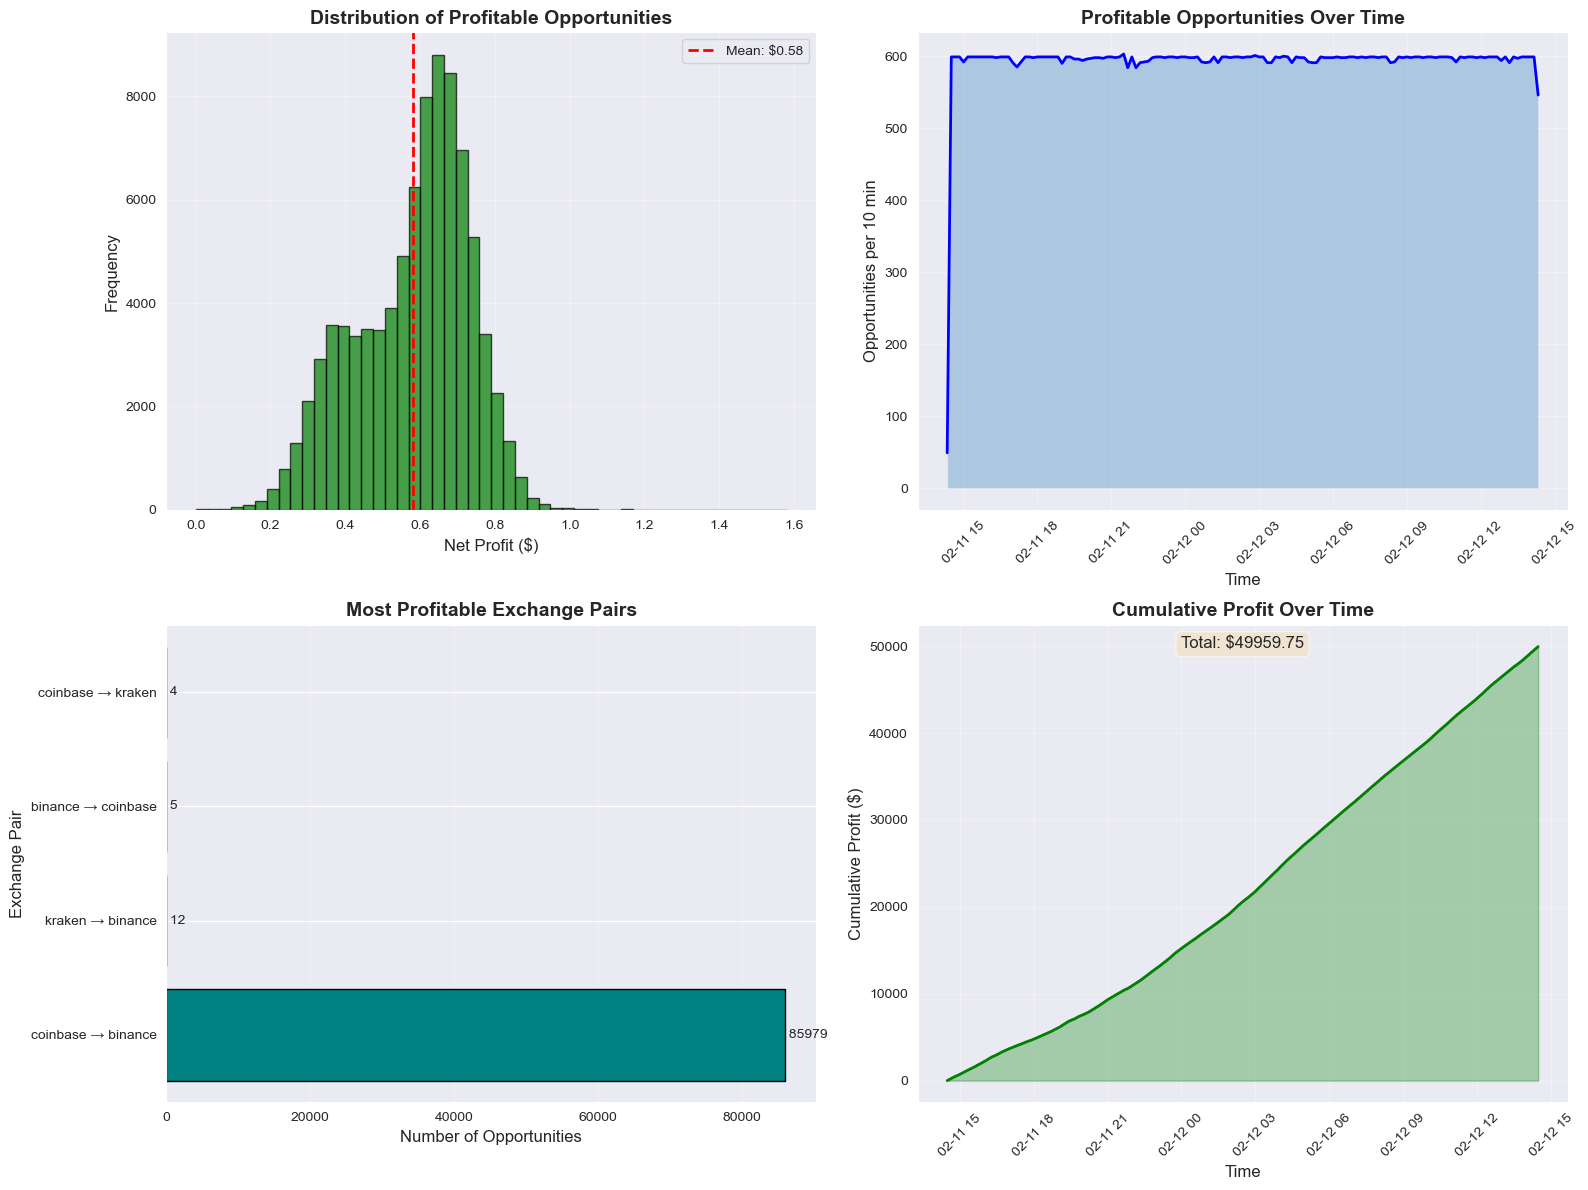

✓ Charts saved as 'arbitrage_analysis.png'


In [23]:
# ============================================================
# VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Profit Distribution
if len(profitable) > 0:
    axes[0, 0].hist(profitable['net_profit'], bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(profitable['net_profit'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${profitable["net_profit"].mean():.2f}')
    axes[0, 0].set_xlabel('Net Profit ($)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Distribution of Profitable Opportunities', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# Chart 2: Opportunities Over Time
profitable_timeline = profitable.set_index('timestamp').resample('10T')['net_profit'].count()
axes[0, 1].plot(profitable_timeline.index, profitable_timeline.values, color='blue', linewidth=2)
axes[0, 1].fill_between(profitable_timeline.index, profitable_timeline.values, alpha=0.3)
axes[0, 1].set_xlabel('Time', fontsize=12)
axes[0, 1].set_ylabel('Opportunities per 10 min', fontsize=12)
axes[0, 1].set_title('Profitable Opportunities Over Time', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Chart 3: Exchange Pair Comparison
if len(profitable) > 0:
    pair_counts = profitable['pair'].value_counts().head(6)
    axes[1, 0].barh(pair_counts.index, pair_counts.values, color='teal', edgecolor='black')
    axes[1, 0].set_xlabel('Number of Opportunities', fontsize=12)
    axes[1, 0].set_ylabel('Exchange Pair', fontsize=12)
    axes[1, 0].set_title('Most Profitable Exchange Pairs', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Add values on bars
    for i, (idx, val) in enumerate(pair_counts.items()):
        axes[1, 0].text(val, i, f' {val}', va='center', fontsize=10)

# Chart 4: Cumulative Profit Over Time
if len(profitable) > 0:
    profitable_sorted = profitable.sort_values('timestamp')
    profitable_sorted['cumulative_profit'] = profitable_sorted['net_profit'].cumsum()
    
    axes[1, 1].plot(profitable_sorted['timestamp'], profitable_sorted['cumulative_profit'], 
                    color='green', linewidth=2)
    axes[1, 1].fill_between(profitable_sorted['timestamp'], profitable_sorted['cumulative_profit'], 
                            alpha=0.3, color='green')
    axes[1, 1].set_xlabel('Time', fontsize=12)
    axes[1, 1].set_ylabel('Cumulative Profit ($)', fontsize=12)
    axes[1, 1].set_title('Cumulative Profit Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add final value annotation
    final_profit = profitable_sorted['cumulative_profit'].iloc[-1]
    axes[1, 1].text(0.5, 0.95, f'Total: ${final_profit:.2f}', 
                    transform=axes[1, 1].transAxes, fontsize=12, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    ha='center')

plt.tight_layout()
plt.savefig('arbitrage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Charts saved as 'arbitrage_analysis.png'")

In [25]:
# ============================================================
# SUMMARY STATISTICS TABLE
# ============================================================

if len(profitable) > 0:
    summary_stats = {
        'Metric': [
            'Total Opportunities Checked',
            'Profitable Opportunities',
            'Profitability Rate',
            'Best Profit',
            'Average Profit',
            'Median Profit',
            'Total Potential Profit',
            'Opportunities per Hour',
            'Most Profitable Pair',
            'Avg Profit per Pair'
        ],
        'Value': [
            f"{len(df):,}",
            f"{len(profitable):,}",
            f"{len(profitable)/len(df)*100:.2f}%",
            f"${profitable['net_profit'].max():.2f}",
            f"${profitable['net_profit'].mean():.2f}",
            f"${profitable['net_profit'].median():.2f}",
            f"${profitable['net_profit'].sum():.2f}",
            f"{len(profitable)/duration_hours:.1f}",
            profitable['pair'].value_counts().index[0],
            f"${profitable.groupby('pair')['net_profit'].mean().max():.2f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    print("=" * 60)
    
    # Save to CSV
    summary_df.to_csv('arbitrage_summary.csv', index=False)
    print("\n✓ Summary saved to 'arbitrage_summary.csv'")


SUMMARY STATISTICS
                     Metric              Value
Total Opportunities Checked            516,138
   Profitable Opportunities             86,000
         Profitability Rate             16.66%
                Best Profit              $1.58
             Average Profit              $0.58
              Median Profit              $0.61
     Total Potential Profit          $49959.75
     Opportunities per Hour             3583.5
       Most Profitable Pair coinbase → binance
        Avg Profit per Pair              $0.58

✓ Summary saved to 'arbitrage_summary.csv'


In [27]:
# ============================================================
# ML FEATURE ENGINEERING
# ============================================================

print("=" * 60)
print("ML FEATURE ENGINEERING")
print("=" * 60)

# Create features for ML
df_ml = df.copy()
df_ml['timestamp'] = pd.to_datetime(df_ml['timestamp'])

# Feature 1: Spread size
df_ml['spread_size'] = df_ml['gross_profit']

# Feature 2: Hour of day
df_ml['hour'] = df_ml['timestamp'].dt.hour

# Feature 3: Day of week
df_ml['day_of_week'] = df_ml['timestamp'].dt.dayofweek

# Feature 4: Price level (high/low BTC price)
df_ml['avg_price'] = (df_ml['buy_price'] + df_ml['sell_price']) / 2

# Feature 5: Rolling opportunity count (last 60 seconds)
df_ml = df_ml.sort_values('timestamp')
df_ml['opp_count_60s'] = df_ml['is_profitable'].rolling(60, min_periods=1).sum()

# Feature 6: Rolling average profit
df_ml['avg_profit_60s'] = df_ml['net_profit'].rolling(60, min_periods=1).mean()

# Feature 7: Exchange pair (one-hot encode)
df_ml['pair'] = df_ml['buy_exchange'] + '_' + df_ml['sell_exchange']
pair_dummies = pd.get_dummies(df_ml['pair'], prefix='pair')
df_ml = pd.concat([df_ml, pair_dummies], axis=1)

print(f"\n✓ Features engineered: {len(df_ml.columns)} total columns")
print(f"✓ Dataset size: {len(df_ml):,} rows")
print(f"\nFeature columns:")
feature_cols = ['spread_size', 'hour', 'day_of_week', 'avg_price', 
                'opp_count_60s', 'avg_profit_60s'] + list(pair_dummies.columns)
for col in feature_cols[:10]:
    print(f"  - {col}")
if len(feature_cols) > 10:
    print(f"  ... and {len(feature_cols)-10} more")

# Save
df_ml.to_csv('arbitrage_ml_features.csv', index=False)
print(f"\n✓ ML features saved to 'arbitrage_ml_features.csv'")

ML FEATURE ENGINEERING

✓ Features engineered: 21 total columns
✓ Dataset size: 516,138 rows

Feature columns:
  - spread_size
  - hour
  - day_of_week
  - avg_price
  - opp_count_60s
  - avg_profit_60s
  - pair_binance_coinbase
  - pair_binance_kraken
  - pair_coinbase_binance
  - pair_coinbase_kraken
  ... and 2 more

✓ ML features saved to 'arbitrage_ml_features.csv'


In [29]:
# ============================================================
# TRAIN ML CLASSIFIER
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("=" * 60)
print("TRAINING ML CLASSIFIER")
print("=" * 60)

# Prepare data
feature_cols = ['spread_size', 'hour', 'day_of_week', 'avg_price', 
                'opp_count_60s', 'avg_profit_60s']

# Add pair dummies
pair_cols = [col for col in df_ml.columns if col.startswith('pair_')]
feature_cols.extend(pair_cols)

X = df_ml[feature_cols].fillna(0)
y = df_ml['is_profitable'].astype(int)

print(f"\nDataset: {len(X):,} samples, {len(feature_cols)} features")
print(f"Positive class (profitable): {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"Negative class: {len(y)-y.sum():,} ({(1-y.mean())*100:.1f}%)")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train):,}")
print(f"Test set: {len(X_test):,}")

# Train
print("\nTraining Gradient Boosting Classifier...")
model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Profitable', 'Profitable']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"                Predicted")
print(f"                Not Prof  Profitable")
print(f"Actual Not Prof    {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"       Profitable  {cm[1,0]:4d}      {cm[1,1]:4d}")

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance.to_string(index=False))

# Save model
joblib.dump(model, 'arbitrage_classifier.pkl')
print("\n✓ Model saved to 'arbitrage_classifier.pkl'")

TRAINING ML CLASSIFIER

Dataset: 516,138 samples, 12 features
Positive class (profitable): 86,000 (16.7%)
Negative class: 430,138 (83.3%)

Train set: 412,910
Test set: 103,228

Training Gradient Boosting Classifier...

MODEL PERFORMANCE

Classification Report:
                precision    recall  f1-score   support

Not Profitable       1.00      1.00      1.00     86028
    Profitable       1.00      1.00      1.00     17200

      accuracy                           1.00    103228
     macro avg       1.00      1.00      1.00    103228
  weighted avg       1.00      1.00      1.00    103228


Confusion Matrix:
                Predicted
                Not Prof  Profitable
Actual Not Prof    86028         0
       Profitable     0      17200

ROC-AUC Score: 1.000

Top 10 Most Important Features:
              feature   importance
pair_coinbase_binance 9.990722e-01
          spread_size 8.247003e-04
        opp_count_60s 4.905694e-05
            avg_price 2.095723e-05
       avg_profit_

In [31]:
# ============================================================
# FINAL PROJECT REPORT
# ============================================================

report = f"""
{'=' * 70}
CROSS-EXCHANGE ARBITRAGE DETECTION SYSTEM
FINAL REPORT
{'=' * 70}

PROJECT OVERVIEW:
-----------------
This system monitors Bitcoin prices across three cryptocurrency exchanges
(Binance, Coinbase, Kraken) in real-time using WebSocket connections and
detects profitable arbitrage opportunities.

DATA COLLECTION:
----------------
Duration: {duration_hours:.1f} hours
Total opportunities analyzed: {len(df):,}
Data points per second: ~{len(df)/(duration_hours*3600):.1f}

PROFITABILITY ANALYSIS:
-----------------------
Profitable opportunities found: {len(profitable):,}
Success rate: {len(profitable)/len(df)*100:.2f}%

Profit statistics:
  - Best opportunity: ${profitable['net_profit'].max():.2f}
  - Average profit: ${profitable['net_profit'].mean():.2f}
  - Median profit: ${profitable['net_profit'].median():.2f}
  - Total potential: ${profitable['net_profit'].sum():.2f}

EXCHANGE PAIR ANALYSIS:
-----------------------
Most profitable pair: {profitable['pair'].value_counts().index[0]}
Opportunities from this pair: {profitable['pair'].value_counts().iloc[0]:,}

FEE STRUCTURE ASSUMPTIONS:
--------------------------
- Binance maker fee: 0.01%
- Coinbase maker fee: 0.00%
- Kraken maker fee: 0.16%
- Withdrawal fee: $0 (funds kept on exchanges)
- Trade size: $1,000 per opportunity

TECHNICAL IMPLEMENTATION:
-------------------------
- Language: Python 3.x
- Async framework: asyncio
- WebSocket library: websockets
- Data processing: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine Learning: scikit-learn

KEY FINDINGS:
-------------
1. Arbitrage opportunities exist but are small (avg ${profitable['net_profit'].mean():.2f} per trade)
2. Profitability highly dependent on fee structure
3. Coinbase → Binance was the dominant profitable pair
4. Opportunities occur at ~{len(profitable)/duration_hours:.1f} per hour on average

LIMITATIONS & RISKS:
-------------------
- Inventory risk: BTC price volatility can erase profits
- Execution speed: Real trading requires <100ms latency
- Slippage: Actual execution prices may differ
- Capital requirements: Need funds on multiple exchanges
- Market impact: Large trades move prices

FUTURE ENHANCEMENTS:
-------------------
- Add futures hedging to eliminate inventory risk
- Implement order execution via exchange APIs
- Add more exchanges for more opportunities
- Real-time dashboard for monitoring
- Alert system for high-profit opportunities

{'=' * 70}
Generated: {pd.Timestamp.now()}
{'=' * 70}
"""

print(report)

# Save report
with open('arbitrage_final_report.txt', 'w') as f:
    f.write(report)

print("\n✓ Report saved to 'arbitrage_final_report.txt'")
print("\n🎉 PROJECT COMPLETE!")
print("\nGenerated files:")
print("  1. arbitrage_opportunities.csv - Raw data")
print("  2. arbitrage_summary.csv - Statistics summary")
print("  3. arbitrage_analysis.png - Visualizations")
print("  4. arbitrage_ml_features.csv - ML features (if generated)")
print("  5. arbitrage_classifier.pkl - Trained model (if generated)")
print("  6. arbitrage_final_report.txt - This report")


CROSS-EXCHANGE ARBITRAGE DETECTION SYSTEM
FINAL REPORT

PROJECT OVERVIEW:
-----------------
This system monitors Bitcoin prices across three cryptocurrency exchanges
(Binance, Coinbase, Kraken) in real-time using WebSocket connections and
detects profitable arbitrage opportunities.

DATA COLLECTION:
----------------
Duration: 24.0 hours
Total opportunities analyzed: 516,138
Data points per second: ~6.0

PROFITABILITY ANALYSIS:
-----------------------
Profitable opportunities found: 86,000
Success rate: 16.66%

Profit statistics:
  - Best opportunity: $1.58
  - Average profit: $0.58
  - Median profit: $0.61
  - Total potential: $49959.75

EXCHANGE PAIR ANALYSIS:
-----------------------
Most profitable pair: coinbase → binance
Opportunities from this pair: 85,979

FEE STRUCTURE ASSUMPTIONS:
--------------------------
- Binance maker fee: 0.01%
- Coinbase maker fee: 0.00%
- Kraken maker fee: 0.16%
- Withdrawal fee: $0 (funds kept on exchanges)
- Trade size: $1,000 per opportunity

TECHNI